In [1]:
#hide
import pandas as pd
from IPython.display import HTML
import matplotlib.pyplot as plt
import proplot as plot
plot.rc['figure.facecolor'] = 'white'
plot.rc['axes.grid'] = False
plot.rc['lines.markeredgewidth'] = 0
plot.rc['image.cmap'] = 'PiYG'

# Authorship identification
> Using machine learning to quantify writing style.
- toc: true 
- badges: false
- comments: true
- categories: [stylometry, machine learning, natural language processing]

In this post, I'll summarize a paper by John Houvardas and Efstathios Stamatatos titled *N-Gram Feature Selection for Authorship Identification* {% cite Houvardas2006 %}. The topic of the paper is *authorship identification*, that is, to identify the author of an unlabeled document given a list of possible authors and some sample of each author's writing. I'll first motivate the problem of authorship identification, then briefly introduce the relevant statistical methods, and finally summarize and implement the methods in the paper. My goal is to reproduce the paper results as a means of learning about the topic.

![](images_2021-04-29/task.png)

## Stylometry

### Motivation: the Federalist Papers

The Federalist Papers are an important collection of 85 essays written by Hamilton, Madison, and Jay during 1787 and 1788. The essays were published under the alias "Plubious", and although it became well-known that the three men were involved, the authorship of each individual paper was kept hidden for over a decade. This was actually in the interest of both Hamilton and Madison; both were politicians who had changed positions on a number of issues and didn't want their political opponents to use their own words against them. Days before his death, Hamilton allegedly wrote down who he believed to be the correct author of each essay, claiming over 60 for himself. Madison waited a number of years before publishing his own list, and in the end there were 12 essays claimed by both Madison and Hamilton. Many interesting details on the controversy can be found in {% cite Adair1944 %}.

<img src=images_2021-04-29/Hamilton_and_Madison.png width=550>
<figcaption>Alexander Hamilton (left) and James Madison (right). Credit: Wikipedia.</figcaption>

There are a few ways one might go about resolving this dispute. One approach is to analyze the actual *content* of the text. For example, perhaps an essay draws from a reference with which only Madison was intimately familiar, or maybe an essay is similar to Hamilton's previous work. This approach was used many times over the next 150 years, but perhaps the final word on the subject was by Adair, who in 1944 concluded that Madison likely wrote all 12 essays. An alternative approach is to analyze the *style* of the text. For example, maybe Madison used many more commas than Hamilton. The field of *stylometry* attempts to statistically quantify these stylistic differences. David Holmes writes the following about stylometry {%cite Holmes1998%}:
> *At its heart lies an assumption that authors have an unconscious aspect to their style, an aspect which cannot consciously be manipulated but which possesses features which are quantifiable and which may be distinctive.* 

I think this a valid assumption. The question is which features best characterize the author's style and which methods are best to use in the analysis of these features. Let's go back in time a bit to see how stylometry has developed over the past 150 years.

### History

The physicist [Thomas Mendenhall](https://en.wikipedia.org/wiki/Thomas_Corwin_Mendenhall) is considered the first to statistically analyze large literary texts. He presented the following interesting idea in an 1887 paper titled [*The Characteristic Curves of Composition*](https://www.jstor.org/stable/pdf/1764604.pdf) {% cite Mendenhall1887 %}: it is known that each chemical element emits light with a unique distribution of wavelengths when it is heated; perhaps each author has a unique distribution of word lengths in the texts they have written. It's a really cool idea, and I highly recommend reading his original paper. Mendenhall tallied word lengths by hand for various books, usually in batches of 1000 words or so. Here is Fig. 2 from his paper which shows the characteristic curves for a few excerpts of *Oliver Twist*.

<img src=images_2021-04-29/Mendenhall_Fig2.png width=400>
<figcaption>Distribution of word lengths in "Oliver Twist". Each curve is for a different sample of 1000 words. From {%cite Mendenhall1887%}.</figcaption>

He showed that these curves are very interesting and that they do reveal similarities between different works by the same author. The use of these statistics for authorship identification was left for future work. 

The next significant advance in the statistical analysis of text was made by Zipf in 1932. Zipf found an interesting relationship between an integer $k$ and the frequency $f(k)$ of the $k$th most frequent word. This is often called a *rank-frequency* relationship, where $k$ is the rank. The scaling law can be written as

$$ f(k) \propto k^{-1}. \tag{1} $$

The idea expressed by this law is that short words are much more frequent than large words. Surprisingly, the law holds up very well, albeit not perfectly, for most texts. *Why* this is the case is still unknown; a comprehensive review of the current state of the law can be found in {%cite Piantadosi2014 %}. The law also shows up in other situations such as national GDP:

<img src=images_2021-04-29/Cristelli_Fig1_big.png width=500>
<figcaption>National GDPs appear to be moving toward the prediction by Zipf's Law (red line). From {% cite Cristelli2012 %}.</figcaption>

The success of Zipf's Law was very encouraging and led to a flurry of new mathematical models. Stylometry reached a landmark case in the 1960's when researchers used the frequency distributions of short function words — words we don't think about too much like "upon" or "therefore" — to support Adair's conclusion that Madison wrote the 12 disputed Federalist Papers. At the end of the day, however, models created in the spirit of Zipf's Law are probably doomed to fail. The "true" underlying model must be very complex due to its dependence on human psychology. There are now many algorithms available which instead build predictive models directly from data, and these can be readily applied to the problem of authorship identification. Here we focus on the use of the Support Vector Machine (SVM).

## Support Vector Machine (SVM)

I include here the basic idea behind the SVM approach. There are a huge number of resources which go into the details (such as {%cite Bishop2006 %}). I'll follow the Wikipedia page since it has a nice short summary.

### Maximum margin hyperplane

Consider a linear binary classifier, i.e., a plane which splits the data into two classes. The equation for a plane in any number of dimensions is 

$$ y(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + w_0 = 0 \tag{2}. $$

This plane is called the *decision surface*; points are assigned to class 1 if $y(\mathbf{x}) > 0$ or class 2 when $y(\mathbf{x}) < 0$. Suppose the data is linearly separable (able to be completely split in two) and that we've found a plane which correctly splits the data. We could then scale the coordinates such that all points with $y(\mathbf{x}) \ge 1$ belong to class 1 and all points with $y(\mathbf{x}) \le -1$ belong to class 2. The separating plane then sits in the middle as in the following figure.

<br>
<img src=images_2021-04-29/svm.png width=250>
<figcaption>Maximum margin separating plane. Credit: Wikipedia.</figcaption>

Notice that the plane could be rotated while still correctly splitting the existing data; the SVM attempts to find the optimal plane by maximizing the orthogonal distance from the decision plane to the closest point. This is known as the *margin*, and it can be shown that it is inversely proportional to the magnitude of $\mathbf{w}$. Thus, the SVM tries to minimize $|\mathbf{w}|^2$ subject to the constraint that all points are correctly categorized. New data is then assigned based on this optimal boundary.

Some datasets won't be linear separable, in which case we can add a penalty function in order to minimize the number of miscategorized points. So, for *N* samples we minimize

$$ \frac{1}{2}|\mathbf{w}|^2 +  C\sum_{i=1}^{N}{\Theta\left[{t_i \, y(\mathbf{x}_i)}\right]} . \tag{3}$$

where $t_i$ is the true class of point $i$, $\Theta$ is the Heaviside step function, and $C$ is a positive constant. Let's try this on non-linearly separable data sampled from two Gaussian distributions in 2D space. The Python package [scikit-learn](https://scikit-learn.org/stable/modules/svm.html) has a user-friendly interface for the SVM implementation in [LIBLINEAR](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) which we use here.

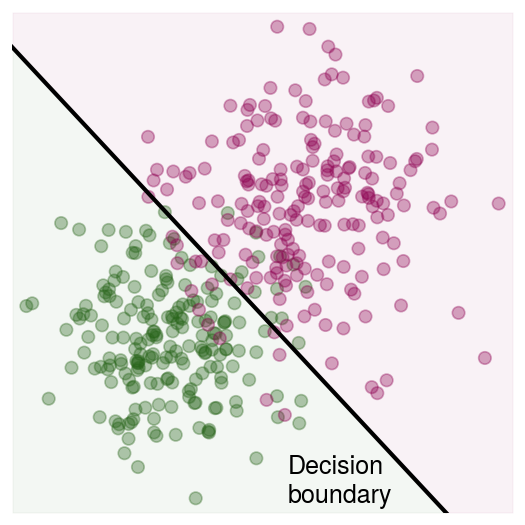

In [2]:
#collapse
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import proplot as plot

# Create two Gaussian distributions
np.random.seed(0)
n = 200
X = np.vstack([np.random.normal(size=(n, 2), loc=[0, 0], scale=2.0),
               np.random.normal(size=(n, 2), loc=[5, 5], scale=2.5)])
y = n * [1] + n * [-1] 

# Find SVM decision boundary 
clf = svm.LinearSVC(C=1)
clf.fit(X, y)

# Plot the data
def despine(ax):
    ax.format(xticks=[], yticks=[])
    for side in ['left', 'right', 'top', 'bottom']:
        ax.spines[side].set_visible(False)

def padded_ranges(X, pad=0.5):
    xmin, ymin = np.min(X, axis=0) - pad
    xmax, ymax = np.max(X, axis=0) + pad
    return (xmin, xmax), (ymin, ymax)
    
def plot_dec_boundary(ax, clf, xlim=(-100, 100), i=0, **kws):
    w0 = clf.intercept_ if type(clf.intercept_) is float else clf.intercept_[i]
    (w1, w2) = clf.coef_[i]
    line_x = np.array(xlim)
    line_y = -(w1 / w2) * line_x - (w0 / w2)
    kws.setdefault('c', 'black')
    ax.plot(line_x, line_y, **kws)
    
def plot_dec_regions(ax, clf, xlim, ylim, nsteps=500, **kws):
    (xmin, xmax), (ymin, ymax) = xlim, ylim
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, nsteps), np.linspace(ymin, ymax, nsteps))
    Z = np.c_[xx.ravel(), yy.ravel()]
    y_pred = clf.predict(Z)
    zz = y_pred.reshape(xx.shape)
    kws.setdefault('alpha', 0.05)
    kws.setdefault('zorder', 0)
    ax.contourf(xx, yy, zz, **kws)
    
fig, ax = plot.subplots()
despine(ax)
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)    
xlim, ylim = padded_ranges(X, pad=0.5)
plot_dec_boundary(ax, clf)
plot_dec_regions(ax, clf, xlim, ylim)
ax.format(xlim=xlim, ylim=ylim)
ax.annotate('Decision\nboundary', xy=(0.55, 0.02), xycoords='axes fraction');

The points are colored by their true classes, and the background is shaded according to the SVM prediction at each point. It can be important to try at least a few different values of $C$, which determines the trade-off between correctly classifying all samples and maximizing the margin, and to observe the effect on the accuracy as well as the algorithm convergence. Parameters such as this one which change the algorithm behavior but aren't optimized by the algorithm itself are commonly known as *hyperparameters*.

### Kernel trick

In some cases the linear model is going to be bad; a frequently used example is "target" dataset.

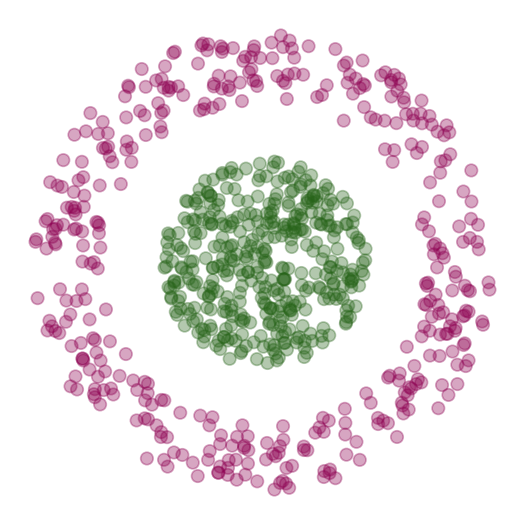

In [3]:
#collapse
n = 400
r1 = np.sqrt(np.random.uniform(0.0, 0.2, size=(n,)))
r2 = np.sqrt(np.random.uniform(0.5, 1.0, size=(n,)))
t1 = np.random.uniform(0, 2*np.pi, size=(n,))
t2 = np.random.uniform(0, 2*np.pi, size=(n,))
X = np.vstack([np.vstack([r1*np.cos(t1), r1*np.sin(t1)]).T,
               np.vstack([r2*np.cos(t2), r2*np.sin(t2)]).T])
y = n * [1] + n * [-1]
xlim, ylim = padded_ranges(X, pad=0.1)

fig, ax = plot.subplots()
despine(ax)
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)
ax.format(xlim=xlim, ylim=ylim)

A line obviously won't work; ideally we would draw a circle around the inner cluster to split the data. The [kernel trick](https://en.wikipedia.org/wiki/Kernel_method) can be used to alleviate this problem by performing a transformation to a higher dimensional space in which the data is linearly separable. For example, consider the transformation

$$ (x_1, x_2) \rightarrow (x_1^2, x_2^2, \sqrt{2} x_1 x_2) . \tag{4}$$

In [4]:
# collapse
from plotly import graph_objects as go

x1, x2 = X.T
u = x1**2
v = np.sqrt(2) * x1 * x2
w = x2**2
fig = go.Figure(data=go.Scatter3d(x=u, y=v, z=w, mode='markers',
                                  marker=dict(color=y, size=3, opacity=0.5)))
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
HTML(fig.to_html(include_plotlyjs='cdn'))

It's clear from rotating this plot that the transformed data can be split with a 2D plane. This need not be the transformation used by the SVM — in fact, many transformations can be used — but it clearly demonstrates the idea. The linear boundary in the transformed space can then be transformed to a nonlinear boundary in the original space. One way to plot this boundary is to make a prediction on a grid of points, then make a contour plot (the boundary is shown in grey).

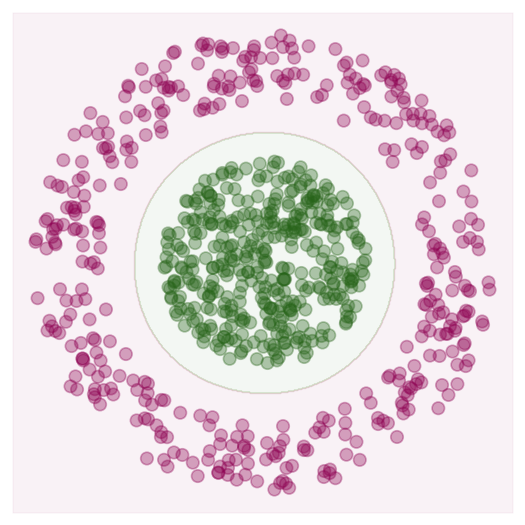

In [5]:
#collapse
clf = svm.SVC(kernel='rbf')
clf.fit(X, y)

fig, ax = plot.subplots()
despine(ax)
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y)
ax.format(xlim=xlim, ylim=ylim)
plot_dec_regions(ax, clf, xlim, ylim)

There are still several advantages to the linear SVM. First, it is much faster to train, and second, the kernel trick may be unnecessary for high-dimensional data. As we'll see, text data can involve a large number of very high-dimensional samples, so we'll be sticking with linear kernels.

### Multi-class 

A binary classifier can also be used for multi-class problems. Here we use the *one-versus-rest*(OVR) approach. Suppose we had $N$ classes denoted by $c_1$, $c_2$ ... $c_N$. In the OVR approach we train $N$ different classifiers; the ith classifier $L_i$ tries to split the data into two parts: $c_i$ and not $c_i$. Then we observe a new point and ask each classifier $L_i$ how confident it is that the point belongs to $c_i$. The point is assigned to the class with the highest score. We can extend our previous example to three Gaussian distributions to get a sense of how the decision boundaries are formed.

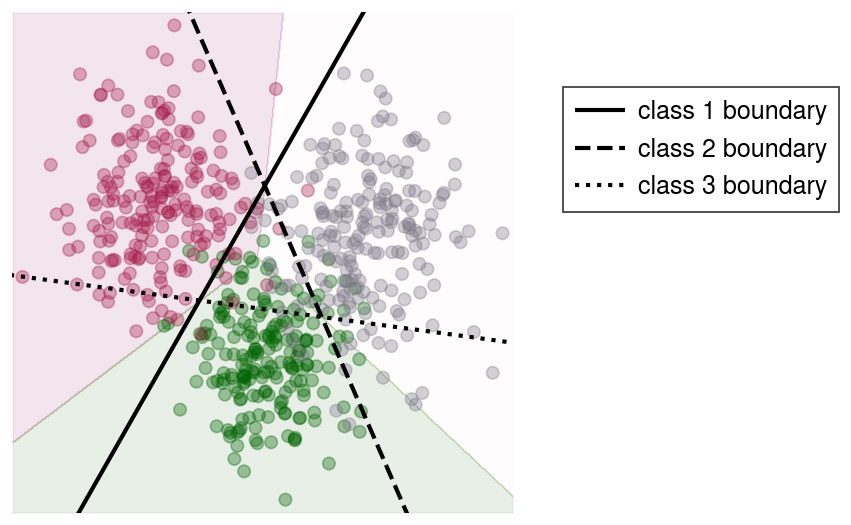

In [6]:
#collapse
# Create three Gaussian distributions
np.random.seed(0)
n = 200
X = np.vstack([np.random.normal(size=(n, 2), loc=[0, 0], scale=2.0),
               np.random.normal(size=(n, 2), loc=[5, 5], scale=2.5),
               np.random.normal(size=(n, 2), loc=[-6, 6], scale=2.5)])
y = n * [1] + n * [0] + n * [-1] 

# Find SVM decision boundary 
clf = svm.LinearSVC(C=1, multi_class='ovr', max_iter=10000)
clf.fit(X, y)

# Plot the data
fig, ax = plot.subplots()
despine(ax)
ax.scatter(X[:, 0], X[:, 1], s=20, alpha=0.35, c=y,
           cmap=plot.Colormap(('pink9', 'grey', 'darkgreen')))

# Plot decision boundary
xlim, ylim = padded_ranges(X)
for i in range(3):
    ls = ['-', '--', 'dotted'][i]
    plot_dec_boundary(ax, clf, i=i, ls=ls)
ax.format(xlim=xlim, ylim=ylim)
ax.legend(labels=['class {} boundary'.format(i) for i in range(1, 4)],
          ncols=1, loc=(1.1, 0.6));
plot_dec_regions(ax, clf, xlim, ylim, alpha=0.1)

The same idea holds with more classes and dimensions. Notice that there are some regions which are claimed by multiple classifiers, so it's not a perfect method.

## N-grams and feature selection methods 

As I mentioned in the introduction, the I'm following is called *N-Gram Feature Selection for Authorship Identification*. In short, the paper used *n-gram* frequencies (defined in a moment) as features in the classification task and developed a new method to select the most significant or "dominant" n-grams. This was tested on a collection of short news articles. Let's step through their method.

### Data set description 

The Reuters Corpus Volume 1 (RCV1) data set is a big collection of news articles labeled by topic. Around 100,000 of these have known authors, and there are around 2000 different authors. A specific topic was chosen, and only authors who wrote at least one article which fell under this topic were considered. From this subset of authors, the top 50 in terms of number of articles written were chosen. 100 articles from each author were selected — 5000 in total — and these were evenly split into a training and testing set. The resulting corpus is a good challenge for authorship identification because the genre is invariant across documents and because the authors write about similar topics. Hopefully this leaves the author's style as the primary distinguishing factor. The data set can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/Reuter_50_50). The files are organized like this:

![](images_2021-04-29/files.png)

There are plenty of functions available to load the data and to extract features from it, but I'll do everything manually just for fun. To load the data, let's first create two lists of strings, `texts_train` and `texts_test`, corresponding to the 2500 training and testing documents. The class id and author name for each document are also stored.

In [7]:
from os import listdir
from os.path import join

def load_files(outer_path):
    texts, class_ids, class_names = [], [], []
    for class_id, folder in enumerate(sorted(listdir(outer_path))):
        folder_path = join(outer_path, folder)
        for filename in listdir(folder_path):
            class_ids.append(class_id)
            class_names.append(folder)
            file = open(join(folder_path, filename), 'r')
            text = file.read().replace(' ', '_')
            texts.append(text)
            file.close()
    return texts, class_ids, class_names

texts_train, y_train, authors_train = load_files('reuters_data/train')
texts_test, y_test, authors_test = load_files('reuters_data/test')

In [8]:
#hide_input
df = pd.DataFrame()
df['Author Name'] = authors_train
df['Author ID'] = y_train
df['Training Text'] = texts_train
df

,Author Name,Author ID,Training Text
0,AaronPressman,0,A_group_of_leading_trademark_specialists_plans...
1,AaronPressman,0,Prospects_for_comprehensive_reform_of_U.S._ban...
2,AaronPressman,0,An_influential_economic_research_group_is_prep...
3,AaronPressman,0,The_Federal_Communications_Commission_proposed...
4,AaronPressman,0,An_international_task_force_charged_with_resol...
...,...,...,...
2495,WilliamKazer,49,China_could_list_more_railway_companies_and_is...
2496,WilliamKazer,49,The_choice_of_Singapore_for_the_listing_of_Chi...
2497,WilliamKazer,49,"China_ushered_in_1997,_a_year_it_has_hailed_as..."
2498,WilliamKazer,49,China_on_Tuesday_announced_a_ban_on_poultry_an...


The following histogram shows the distribution of document lengths in the training set; it's expected that the short average document length will greatly increases the difficulty of the classification task relative to longer works such as books.

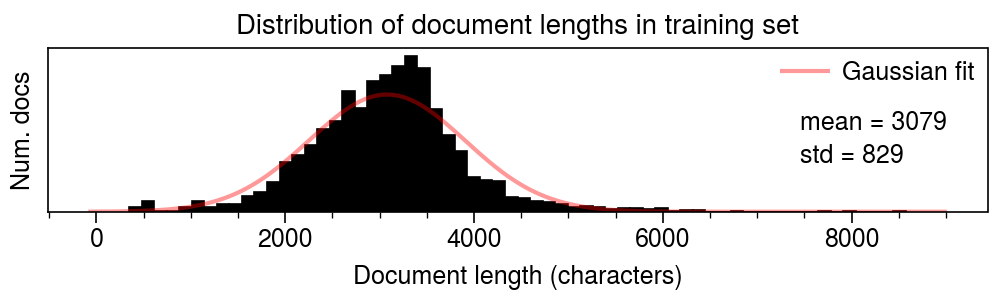

In [9]:
#collapse
word_counts = [len(text) for text in texts_train]

fig, ax = plot.subplots(figsize=(5, 1.5))
ax.hist(word_counts, bins='auto', color='k', density=True)
ax.format(xlabel='Document length (characters)', ylabel='Num. docs', yticks=[], 
          title='Distribution of document lengths in training set')
ax.annotate(r'mean = {:.0f}'.format(np.mean(word_counts)), xy=(0.8, 0.5), 
            xycoords='axes fraction')
ax.annotate('std = {:.0f}'.format(np.std(word_counts)), xy=(0.8, 0.3), 
            xycoords='axes fraction');

from scipy.stats import norm
mean, std = norm.fit(word_counts)
x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 1000)
y = norm.pdf(x, mean, std)
ax.plot(x, y, c='red', alpha=0.4);
ax.legend(labels=['Gaussian fit'], frameon=False);

### N-grams

An obvious feature candidate is word frequency; a less obvious one is *n-gram* frequency. A character n-gram is a string of length n. For example, the 3-grams contained in *red_bike!* are *red*, *ed_*, *d_b*, *_bi*, *bik*, *ike*, *ke!*. These shorter strings may be useful because they capture different aspects of style such as the use of punctuation or certain prefixes/suffixes. They also remove any ambiguities in word extraction (is *two-fold* aa single word?) and work for all languages. In order to use these features in the SVM classifier, we need to create a feature matrix $X$ where $X_{ij}$ is the frequency of the jth n-gram in the ith document. Thus, each document is represented as a vector in $k$ dimensional space, where $k$ is the number of unique n-grams selected from the training documents. We'll also normalize each vector so that all points are mapped onto the surface of the $k$-dimensional unit sphere while preserving the angles between the vectors; this should help the SVM performance a bit.

In [10]:
from collections import Counter

def get_ngrams(text, n):
    return [text[i - n : i] for i in range(n, len(text) + 1)]

def get_ngrams_in_range(text, min_n, max_n):
    ngrams = []
    for n in range(min_n, max_n + 1):
        ngrams.extend(get_ngrams(text, n))
    return ngrams

def sort_by_val(dictionary, max_items=None, reverse=True):
    n_items = len(dictionary)
    if max_items is None or max_items > n_items:
        max_items = n_items
    sorted_key_val_list = sorted(dictionary.items(), key=lambda item: item[1], 
                                 reverse=reverse)
    return {k: v for k, v in sorted_key_val_list[:max_items]}


class NgramExtractor:
    
    def __init__(self, ngram_range=(3, 5)):
        self.vocab = {}
        self.set_ngram_range(ngram_range)
        
    def set_ngram_range(self, ngram_range):
        self.min_n, self.max_n = ngram_range
        
    def build_vocab(self, texts, max_features=None):
        self.vocab, index = {}, 0
        for n in range(self.min_n, self.max_n + 1):
            ngrams = []
            for text in texts:
                ngrams.extend(get_ngrams(text, n))
            counts = sort_by_val(Counter(ngrams), max_features)
            for ngram, count in counts.items():
                self.vocab[ngram] = (index, count)
                index += 1
    
    def create_feature_matrix(self, texts, norm_rows=True):
        X = np.zeros((len(texts), len(self.vocab)))
        for text_index, text in enumerate(texts):
            ngrams = get_ngrams_in_range(text, self.min_n, self.max_n)
            for ngram, count in Counter(ngrams).items():
                if ngram in self.vocab:
                    term_index = self.vocab[ngram][0]
                    X[text_index, term_index] = count
        if norm_rows:
            X = np.apply_along_axis(lambda row: row / np.linalg.norm(row), 1, X)
        return X

Now we need to decide which value(s) of n to use as features. Let's look at the distribution of n-grams in the training documents.

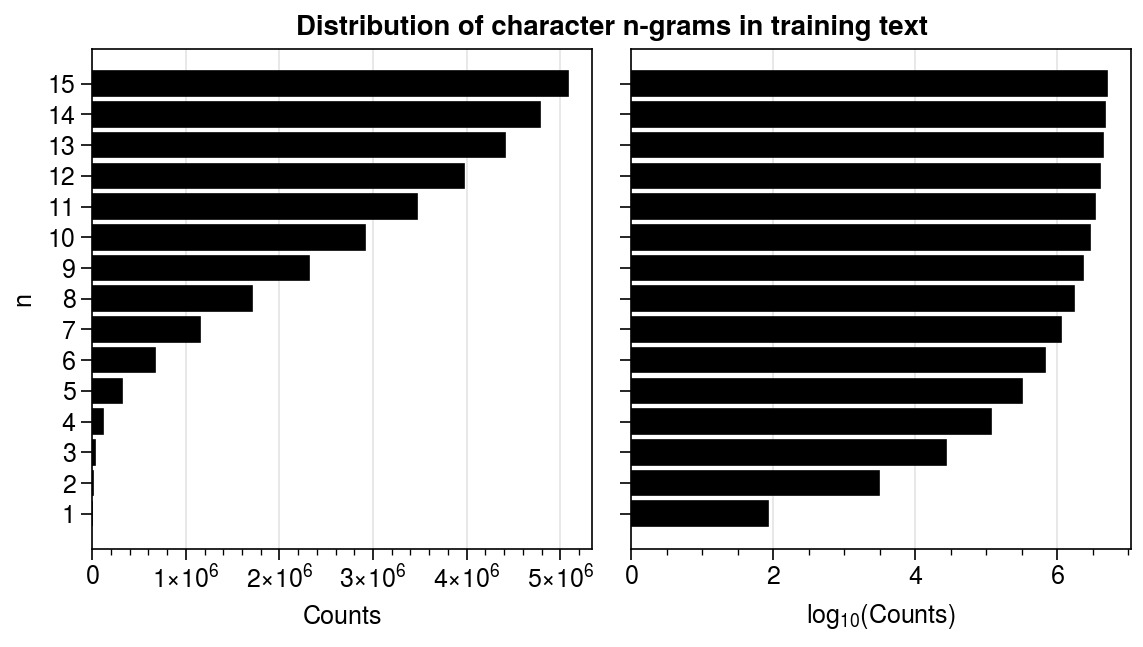

In [11]:
#collapse
extractor = NgramExtractor(ngram_range=(1, 15))
extractor.build_vocab(texts_train)
len_counts = Counter([len(ngram) for ngram in extractor.vocab.keys()])

fig, axes = plot.subplots(ncols=2, sharex=False)
x, y = zip(*len_counts.items())
axes[0].barh(x, y, color='k')
axes[1].barh(x, np.log10(y), color='k')
axes.format(yticks=x, ytickminor=False, ylabel='n',
            suptitle='Distribution of character n-grams in training text')
axes[0].format(xlabel='Counts', xformatter='sci')
axes[1].format(xlabel='log$_{10}$(Counts)', xformatter='sci')
for ax in axes:
    ax.grid(axis='x')

The total number of n-grams with 1 $\le$n $\le$ 15 is about 31 million; training a classifier on data with this number of dimensions is probably infeasible, and even more so on a larger data set. Previous studies have apparently had success with fixing the value of n to be either 3, 4, or 5, so the authors chose to restrict their attention to these values. Their new idea was to use all n-grams in the range 3 $\le$n $\le$ 5. This leaves a few hundred thousand features.

The next section will discuss statistical methods to prune the features; for now, though, we'll implement the simple method of keeping the $k$ most frequent across all the training documents. As long as this doesn't affect the accuracy too much, we reap the benefits of a reduction in computational time and the ability to fix the feature space dimensionality for comparison of different feature types. To see why many low frequency terms may be unimportant, suppose one of the authors wrote a single article about sharks in the training set. The the term "shark" would have a small global frequency and be very useful in the training set since no other writers write about sharks, but it's probabably a good idea to discard it since its unlikely to appear in the testing set. We must be careful, however, because some low-frequency terms could be important. These are probably terms which an author uses rarely but consistently over time. Maybe they like to use "incredible" as an adjective; the global frequency of "incred" would be much less than, say, "that_", but it's valuable because its frequency distribution will likely be the same in future writing. A quick test on our data set shows that $k$ = 15,000 is a good number. Let's try this out on the 15,000 most frequent 3-grams.

In [12]:
ngram_range = (3, 3)
max_features = 15000
norm_rows = True

extractor = NgramExtractor(ngram_range)
extractor.build_vocab(texts_train, max_features)
X_train = extractor.create_feature_matrix(texts_train, norm_rows)
X_test = extractor.create_feature_matrix(texts_test, norm_rows)

Here are some of the values in `X_train`. The columns have been sorted by descending frequency from left to right. 

In [13]:
#hide_input
df = pd.DataFrame(X_train, columns=extractor.vocab.keys())
df

,_th,he_,the,_in,ed_,_to,ng_,ing,to_,_of,...,Agi,gip,L_I,+12,n\t\t,_VW,VW_,ig.,kw_,d-n
0,0.129339,0.129339,0.086226,0.129339,0.086226,0.043113,0.129339,0.129339,0.043113,0.086226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.278956,0.266276,0.272616,0.088759,0.088759,0.044379,0.145818,0.133138,0.044379,0.069739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.308339,0.247880,0.266018,0.108825,0.102780,0.102780,0.120917,0.114871,0.102780,0.096734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.244807,0.244807,0.231207,0.102003,0.108803,0.102003,0.061202,0.068002,0.108803,0.108803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.231920,0.248486,0.207072,0.066263,0.149092,0.115960,0.066263,0.066263,0.074546,0.082829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.148444,0.197926,0.141375,0.091894,0.077756,0.127238,0.247407,0.162582,0.106032,0.162582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,0.264067,0.193649,0.211254,0.146704,0.158440,0.082154,0.146704,0.228858,0.082154,0.193649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.346437,0.276067,0.276067,0.092022,0.151566,0.113675,0.276067,0.151566,0.102849,0.151566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.286280,0.293262,0.251367,0.125684,0.181543,0.111719,0.104736,0.076807,0.104736,0.160596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can now feed this array to the SVM and make predictions on the testing data. I'll keep the $C$ parameter fixed at $C = 1$ in all cases since this is what is done in the paper (I tried a few different values of $C$ and there wasn't a large effect on the accuracy). Here is the confusion matrix obtained after training and testing:

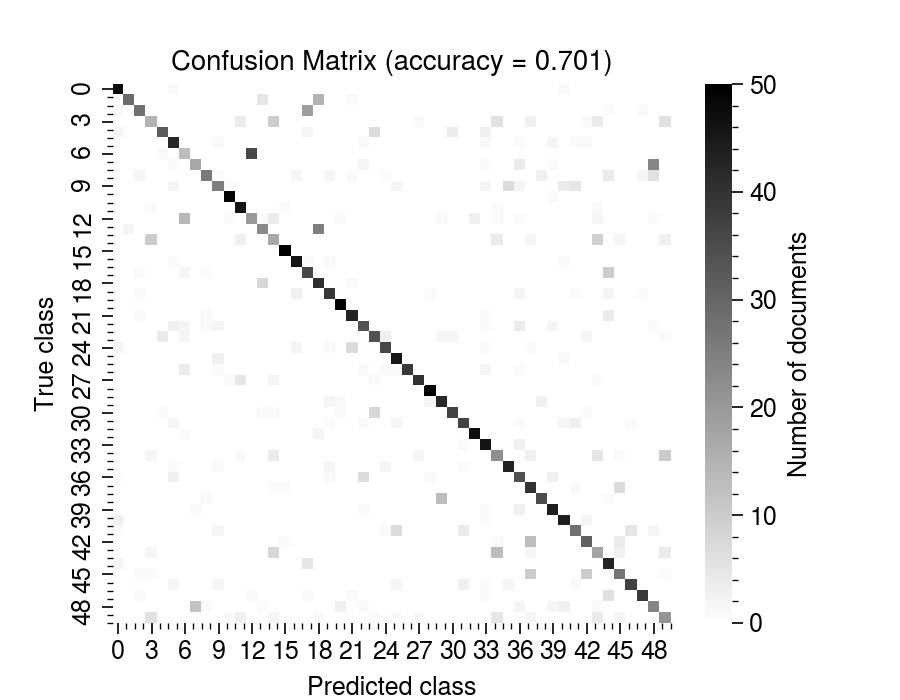

In [14]:
#collapse
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

clf = svm.LinearSVC(C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cmat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(4.5, 3.5))
sns.heatmap(cmat, ax=ax, cmap='binary', cbar_kws=dict(label='Number of documents'))
ax.set_title('Confusion Matrix (accuracy = {:.3f})'.format(acc))
ax.set_ylabel('True class'); ax.set_xlabel('Predicted class');

### Feature selection

In the rest of this post, we'll study how to use statistical methods to further eliminate features from this initial set of 15,000. This process of selecting features which are "best" in a statistical sense is known as *feature selection*.

#### Information gain

A classical statistical measure of feature "goodness" is called *information gain* (IG). The idea is that knowing whether or not a term *t* is found in a document of a known class $c$ gives information about $c$, and that some terms will contribute more information than others. The information gain can be written as {% cite Yang1997 %}

$$ IG(t) = p(t) \sum_{i=1}^{m}p(c_i | t) \log p(c_i | t) +  p(\bar{t}) \sum_{i=1}^{m}p(c_i | \bar{t}) \log p(c_i | \bar{t}) -\sum_{i=1}^{m}p(c_i) \log p(c_i). \tag{5}$$

The probability of choosing term $t$ out of all terms in the corpus is given by $p(t)$, and $p(t) + p(\bar{t}) = 1$. Similarly, $p(c_i)$ is the probability that a randomly chosen document belongs to class $c_i$, and $p(c_i) + p(\bar{c_i}) = 1$. The probability that a document belongs to $c_i$ given that it contains $t$ is $p(c_i | t)$, or $p(c_i | \bar{t})$ if it doesn't contain $t$. The strategy is then to keep the terms with the highest information gain scores. 

In [15]:
class InfoGainSelector:
    
    def __init__(self):
        self.idx = None
        
    def fit(self, X, y):
        # Compute probability distributions
        n_docs, n_terms = X.shape
        n_classes = len(np.unique(y))
        P_c_and_t = np.zeros((n_classes, n_terms))
        for doc_index, class_index in enumerate(y):
            P_c_and_t[class_index, :] += (X[doc_index, :] > 0).astype(int)
        P_c_and_t /= np.sum(P_c_and_t)
        P_t = np.sum(P_c_and_t, axis=0)
        P_c = np.sum(P_c_and_t, axis=1)
        P_c_given_t = P_c_and_t / P_t
        P_c_given_tbar = 1 - (1 - P_c_and_t) / (1 - P_t)
        
        # Compute information gain for each feature
        def XlogX(X):
            return X * np.log2(X, out=np.zeros_like(X), where=(X > 0))
        scores = np.zeros(n_terms)
        scores += np.sum(P_t * XlogX(P_c_given_t), axis=0)
        scores += np.sum((1 - P_t) * XlogX(P_c_given_tbar), axis=0)
        scores -= np.sum(XlogX(P_c))
        self.idx = np.argsort(scores)
        
    def select(self, X, k=-1):  
        return X[:, self.idx[:k]]

We'll now compare 4 sets of 15,000 features: 3-grams, 4-grams, 5-grams, and equal parts 3/4/5-grams, each time using IG to select the best $k$ features and plotting the accuracy vs. $k$. I'll start from $k$ = 1 to 200.

In [16]:
#collapse
extractor = NgramExtractor()
selector = InfoGainSelector()
clf = svm.LinearSVC(C=1)

def compare_acc_ig(ngram_ranges, kmin, kmax, kstep):
    n_keep = np.arange(kmin, kmax + kstep, kstep).astype(int)
    accuracies = np.zeros((len(ngram_ranges), len(n_keep)))
    for i, ngram_range in enumerate(ngram_ranges):
        extractor.set_ngram_range(ngram_range)
        max_features = 5000 if ngram_range == (3, 5) else 15000
        extractor.build_vocab(texts_train, max_features)
        X_train = extractor.create_feature_matrix(texts_train)
        X_test = extractor.create_feature_matrix(texts_test)
        selector.fit(X_train, y_train)
        for j, k in enumerate(n_keep):
            X_train_red = selector.select(X_train, k)
            X_test_red = selector.select(X_test, k)
            clf.fit(X_train_red, y_train)
            y_pred = clf.predict(X_test_red)
            accuracies[i, j] = accuracy_score(y_test, y_pred)
    return accuracies

def plot_accs(accuracies, kmin, kmax, kstep):
    fig, ax = plot.subplots(figsize=(4, 3))
    for i in range(4):
        m = ['D', 's', '^', 's'][i]
        mfc = [None, None, 'w', 'w'][i]
        ax.plot(np.arange(kmin, kmax + kstep, kstep), accuracies[i, :], 
                marker=m, mew=1, mfc=mfc)
    ax.format(title='Information Gain feature selection')
    ax.format(xlabel='Number of features selected (k)')
    ax.format(ylabel='Accuracy')
    ax.legend(labels=['n = 3', 'n = 4', 'n = 5', 'n = (3, 4, 5)'], ncols=1);
    return ax

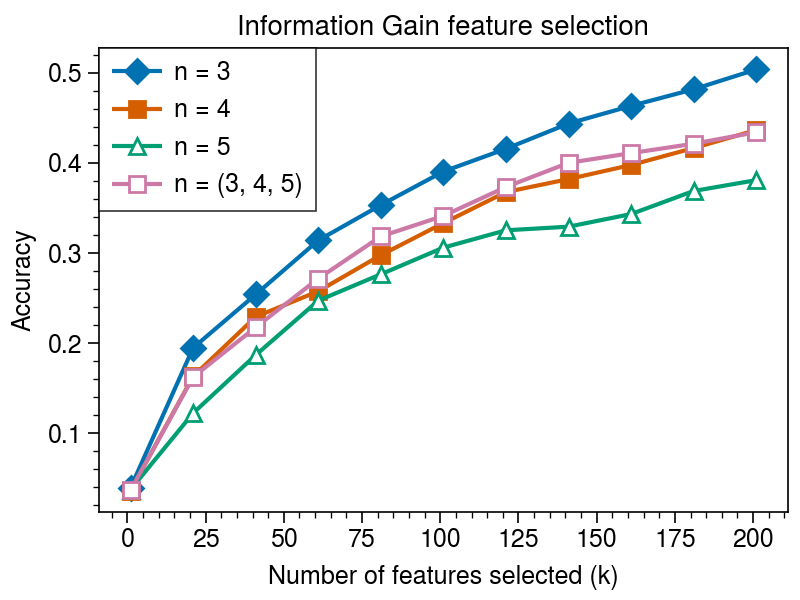

In [17]:
#hide_input
ngram_ranges = [(3, 3), (4, 4), (5, 5), (3, 5)]
kmin, kmax, kstep = 1, 201, 20
accuracies = compare_acc_ig(ngram_ranges, kmin, kmax, kstep)
plot_accs(accuracies, kmin, kmax, kstep);

The accuracy at $k$ = 1 is 0.04, so using the feature with the highest IG score is actually twice as effective as random guessing! By the end of the plot 3-grams and variable length n-grams have taken a clear leaad, with 5-grams in last place. The performance gap between the different n-grams also appears to be growing with $k$. The next region we'll look at is $200 \le k \le 2000$.

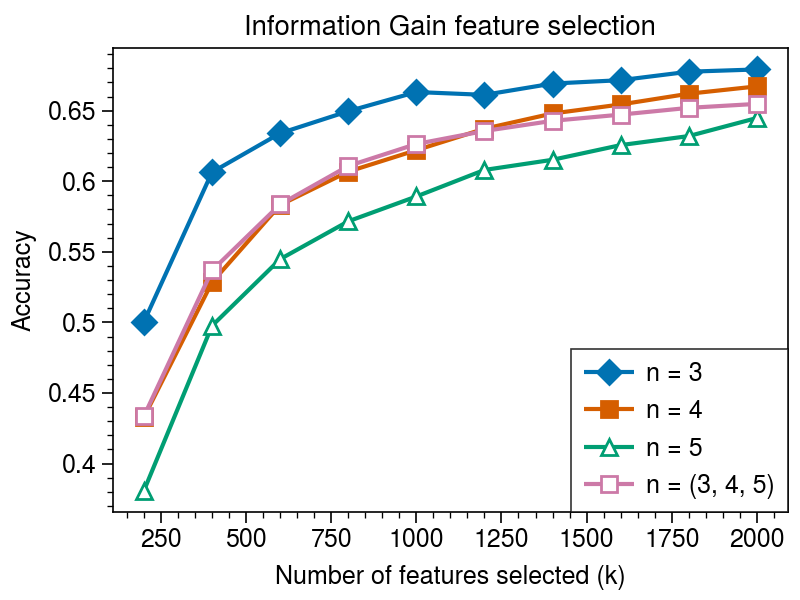

In [18]:
#hide_input
kmin, kmax, kstep = 200, 2000, 200
accuracies = compare_acc_ig(ngram_ranges, kmin, kmax, kstep)
plot_accs(accuracies, kmin, kmax, kstep);

Now the gap is decreasing as we approach an upper performance limit at higher $k$, especially for 3-grams. We'll now look at the region which is plotted in the paper: $2,000 \le k \le 10,000$.

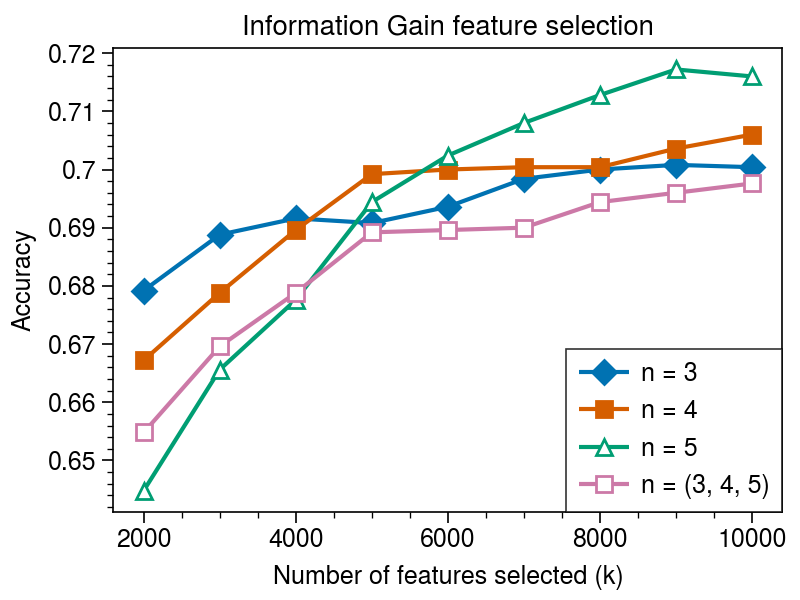

In [19]:
#hide_input
kmin, kmax, kstep = 2000, 10000, 1000
accuracies = compare_acc_ig(ngram_ranges, kmin, kmax, kstep)
plot_accs(accuracies, kmin, kmax, kstep);

One interesting thing is that 5-grams make a big jump from last place to first place. I'm not sure if I have any deep insights into this behavior, but it's interesting that the best n-gram to choose depends on the number of features selected. Now, I should compare with Fig. 1 from the paper:

![](images_2021-04-29/stamatatos_fig1.png)

The first difference is the maximum achieved accuracy which is a few percentage points higher. The second difference is that the authors found 3-grams to be worst at low $k$ and best at high $k$.and the opposite for 5-grams. I'll leave this as an open problem for now.

#### LocalMaxs algorithm

Let's look at the top IG scoring n-grams from from the variable-length feature set.

In [20]:
#collapse
extractor.set_ngram_range((3, 5))
extractor.build_vocab(texts_train, max_features=5000)
X_train = extractor.create_feature_matrix(texts_train)
X_test = extractor.create_feature_matrix(texts_test)
selector.fit(X_train, y_train)

def get_term(i):
    for key, (idx, count) in extractor.vocab.items():
        if idx == i:
            return key
        
for rank, i in enumerate(selector.idx[:10], start=1):
    print('{:02}. {}'.format(rank, get_term(i)))

01. _th
02. _the_
03. the_
04. _to
05. _the
06. _in
07. he_
08. ed_
09. the
10. on_


Notice all the variants of *the* which were included. IG has no way of knowing that these are basically the same. This motivates the definition of something called "glue". Consider the word bigram *Amelia Earhart*. These two words are very likely to be found next to each other and could probably be treated as a single multi-word unit; it is as if there is a glue holding the two words together. The amount of glue is probably higher than that between, say, *window* and *Earhart*. A technique has been developed to quantify this glue and extend its calculation to word n-grams instead of just word bi-grams {% cite Silva2009 %}. The same idea can then be applied to character n-grams.

Let $g(C)$ be the glue of character n-gram $C = c_1 \dots c_n$. Assuming we had a way to calculate the glue, how could this concept be used for feature selection? One solution is called the LocalMaxs algorithm. First define an antecedent $ant(C)$ as an (n-1)-gram which is contained in $C$, e.g., "string" $\rightarrow$ "strin" or "tring". Then define a successor $succ(C)$ as an (n+1)-gram which contains $C$, e.g., "string" $\rightarrow$ "strings" or "astring". *C* is selected as a feature if

$$ g(C) \ge g(ant(C)) \,\, and \,\, g(C) > g(succ(C)) \tag{6}$$

for all *ant*(C) and *succ*(C). Since we're dealing with 3 $\le$ n $\le$ 5, only the latter condition is checked if n = 3, and only the former condition is checked for n = 5. Eq. (6) says that the glue of a selected feature shouldn't increase by adding a character to or removing a character from the start or end of the n-gram, i.e., the glue is at a local maximum with respect to similar n-grams. Now that the selection criteria are established, we can move on to calculating the glue. Here there are several options, but the one used in the paper is called *symmetrical conditional probability* (SCP). If we have a bigram $C = c_1c_2$, then

$$ SCP(c_1c_2) = p(c_1|c_2) \cdot p(c_2|c_1) = \frac{p(c_1,c_2)^2}{p(c_1)p(c_2)}, \tag{7}$$

so SCP is a measure of how likely one character is given the other and vice versa. This formula can be applied to an n-gram $C = c_1\dots c_n$ by performing a *pseudo bigram transformation*, which means splitting the n-gram into two parts at a chosen *dispersion point*; for example, "help" could be split as "h\*elp", "he\*lp", or "hel\*p", where * is the dispersion point. Splitting $C$ as $c_1 \dots c_{n-1}$*$c_n$ would give

$$ SCP((c_1 \dots c_{n-1})c_n) = \frac{p(c_1 \dots c_n)^2}{p(c_1 \dots c_{n-1})p(c_n)}. \tag{8}$$

Of course, the answer will depend on the dispersion point. We therefore introduce the FairSCP which averages over the possible dispersion points:

$$ FairSCP(c_1 \dots c_n) = \frac{p(c_1 \dots c_n)^2}{\frac{1}{n-1}\sum_{i=1}^{n-1} p(c_1 \dots c_i)p(c_{i+1} \dots c_n)}. \tag{9}$$

In summary, LocalMaxs loops through every n-gram in the vocabulary, computes the glue as $g(C) = FairSCP(C)$, and keeps the n-gram if Eq. (6) is satisfied. It differs from IG selection in that the features are not ranked, so the number of selected features is completely determined by the text. The method is implemented below.

In [21]:
import string

def antecedents(ngram):
    return [ngram[:-1], ngram[1:]]

def successors(ngram, characters=None):
    if characters is None:
        characters = string.printable
    successors = []
    for character in characters:
        successors.append(character + ngram)
        successors.append(ngram + character)
    return successors

In [22]:
class LocalMaxsExtractor(NgramExtractor):
    
    def __init__(self, ngram_range=(3, 5)):
        super().__init__(ngram_range)
        self.counts_list = [] # ith element is dictionary of unique (i+1)-gram counts 
        self.sum_counts_list = [] # ith element is the sum of `counts_list[i].values()`
        
    def build_vocab(self, texts, max_features=None):
        # Count all n-grams with n <= self.max_n
        self.counts_list, self.sum_counts_list = [], []
        candidate_ngrams = {}
        for n in range(1, self.max_n + 1):
            ngrams = []
            for text in texts:
                ngrams.extend(get_ngrams(text, n))
            counts = Counter(ngrams)
            self.counts_list.append(counts)
            self.sum_counts_list.append(sum(counts.values()))
            if self.min_n <= n <= self.max_n:
                candidate_ngrams.update(sort_by_val(counts, max_features))
        self.available_characters = self.counts_list[0].keys()    
        # Select candidate n-grams whose glue is at local maximum 
        self.vocab, index = {}, 0
        for ngram, count in candidate_ngrams.items():
            if self.is_local_max(ngram):
                self.vocab[ngram] = (index, count)
                index += 1
                    
    def is_local_max(self, ngram):
        glue, n = self.glue(ngram), len(ngram)
        if n < self.max_n:
            for succ in successors(ngram, self.available_characters):
                if self.glue(succ) >= glue:
                    return False
        if n > self.min_n:
            for ant in antecedents(ngram):
                if self.glue(ant) > glue:
                    return False 
        return True
                    
    def glue(self, ngram):
        n = len(ngram)
        P = self.counts_list[n-1].get(ngram, 0) / self.sum_counts_list[n-1]
        if P == 0:
            return 0.0
        Avp = 0.0
        for disp_point in range(1, n):
            ngram_l, ngram_r = ngram[:disp_point], ngram[disp_point:]
            n_l, n_r = disp_point, n - disp_point
            P_l = self.counts_list[n_l-1].get(ngram_l, 0) / self.sum_counts_list[n_l-1]
            P_r = self.counts_list[n_r-1].get(ngram_r, 0) / self.sum_counts_list[n_r-1]
            Avp += P_l * P_r
        Avp /= (n - 1)
        return P**2 / Avp

The first thing we should do is check the the glue of the derivative n-grams *the*, *_the*, etc. 

In [23]:
extractor = LocalMaxsExtractor(ngram_range=(3, 5))
extractor.build_vocab(texts_train)
for ngram in ['the', '_the', 'the_', '_the_']:
    glue = extractor.glue(ngram)
    selected = extractor.is_local_max(ngram)
    freq = extractor.counts_list[len(ngram) - 1][ngram]
    print('{:<5}: glue = {:.4f}, selected = {}'.format(ngram, glue, selected))

the  : glue = 0.0856, selected = True
_the : glue = 0.0846, selected = False
the_ : glue = 0.0748, selected = False
_the_: glue = 0.0808, selected = False


It seems to be working correctly. Now we'd like to compare the performance to IG. There's no way to directly compare since LocalMaxs doesn't rank features; however, it's possible to vary the size of the initial set of features from which LocalMaxs makes its selections. Below, this initial size is varied from 3,000 to 24,000 using equal parts 3/4/5 grams as features.

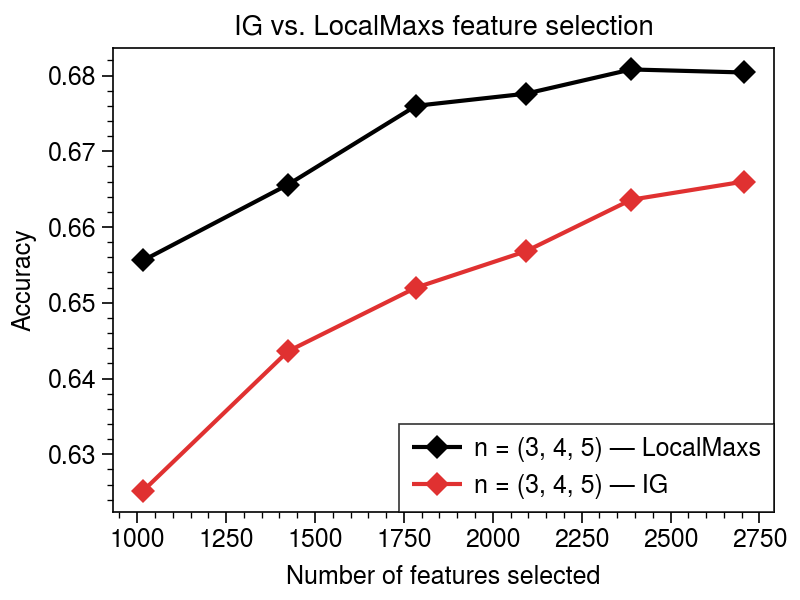

In [24]:
#collapse
lm_extractor = LocalMaxsExtractor(ngram_range=(3, 5))
clf = svm.LinearSVC(C=1)
max_features_list = np.arange(2000, 8000, 1000).astype(int)
lm_accuracies, lm_vocabs = [], []
for max_features in max_features_list:
    lm_extractor.build_vocab(texts_train, max_features)
    X_train_red = lm_extractor.create_feature_matrix(texts_train)
    X_test_red = lm_extractor.create_feature_matrix(texts_test)
    clf.fit(X_train_red, y_train)
    y_pred = clf.predict(X_test_red)
    lm_accuracies.append(accuracy_score(y_test, y_pred))
    lm_vocabs.append(lm_extractor.vocab)
    
n_keep = [len(vocab) for vocab in lm_vocabs]
ig_extractor = NgramExtractor(ngram_range=(3, 5))
ig_extractor.build_vocab(texts_train, max_features=5000)
X_train = ig_extractor.create_feature_matrix(texts_train)
X_test = ig_extractor.create_feature_matrix(texts_test)
ig_selector = InfoGainSelector()
ig_selector.fit(X_train, y_train)
ig_accuracies, ig_vocabs = [], []
for lm_vocab in lm_vocabs:
    k = len(lm_vocab)
    X_train_red = ig_selector.select(X_train, k)
    X_test_red = ig_selector.select(X_test, k)
    clf.fit(X_train_red, y_train)
    y_pred = clf.predict(X_test_red)
    ig_accuracies.append(accuracy_score(y_test, y_pred))
    ig_vocabs.append(extractor.vocab)
    
fig, ax = plot.subplots(figsize=(4, 3))
ax.plot(n_keep, lm_accuracies, c='k', marker='D')
ax.plot(n_keep, ig_accuracies, marker='D', c='red8')
ax.format(xlabel='Number of features selected', ylabel='Accuracy', 
          title='IG vs. LocalMaxs feature selection')
ax.legend(labels=['n = (3, 4, 5) — LocalMaxs', 'n = (3, 4, 5) — IG'], ncols=1);

As you can see, LocalMaxs achieves a higher accuracy with the same number of features. The neat thing is that the vocabularies are totally different; for example, at the last data point, only about 15% of the n-grams are found in both sets! Let's count the number of related n-grams in the two sets, where x is related to y if x is an antecedent or successor of y.

In [25]:
#collapse
def count_related(ngrams):
    count = 0
    for n1 in ngrams:
        for n2 in ngrams:
            if n1 != n2 and n1 in n2:
                count += 1
                break
    return count

lm_ngrams = list(lm_vocabs[-1])
vocab_size = len(lm_ngrams)
ig_vocab = list(ig_extractor.vocab)
ig_ngrams = [ig_vocab[i] for i in ig_selector.idx[:vocab_size]]
shared = len([ig_ngram for ig_ngram in ig_ngrams if ig_ngram in lm_ngrams])

print('Vocab size: {}'.format(vocab_size))
print('n-grams selected by both IG and LM: {}'.format(shared))
print('IG related n-grams: {}'.format(count_related(ig_ngrams)))
print('LM related n-grams: {}'.format(count_related(lm_ngrams)))

Vocab size: 2706
n-grams selected by both IG and LM: 426
IG related n-grams: 1413
LM related n-grams: 178


As mentioned earlier, IG selects many related terms such as *the* and *the_*. The LocalMaxs vocabulary is much "richer", as the authors put it. Here is the corresponding figure from the paper (ignore the white squares):

![](images_2021-04-29/stamatatos_fig2.png)

For some reason, their implementation extracted way more features than mine did. I don't have access to the author's code, and I couldn't find any implementation of LocalMaxs online, so it's hard for me to say what's happening. I'm happy with my implementation since it exhibits the expected behavior (less related terms, better performance at lower feature numbers).

## Conclusion

This post summarized a research paper in the field of Natural Language Processing (NLP). I think that writing such a summary is a good way to learn about a new topic. I didn't exactly reproduce the authors' results, so if anyone reads this (unlikely) and finds a mistake, I would love to know about it.

In a future post I may apply these methods to my own data set; I'm particularly interested in what would happen with [Chinese characters](https://en.wikipedia.org/wiki/Chinese_characters). There are, of course, a ton of different techniques and experiments to explore which involve NLP. A different problem I'd like to examine is that of *artist* identification; the problem would be to match a collection of paintings with their painters. The [Web Gallery of Art](https://www.wga.hu/index.html) is a potential database that I found after a quick search, and I'm sure there are others. This would give me the chance to learn about image classification techniques.

**References**

{% bibliography --cited %}